In [1]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13106/3166594014.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 243


In [4]:
n_stocks = 10
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)
# sp500[sp500['Symbol'].isin(portfolio_tickers)]

['DIS', 'BIIB', 'GILD', 'ETR', 'PEP', 'NVDA', 'NI', 'BBWI', 'SWK', 'CBRE']


In [5]:
# tickers = ['AAPL', 'GOOGL', 'MSFT','SPY']
# start_date='2007-01-01'
# end_date='2022-12-31'
# columns = ['Adj Close', 'Volume']
# # Download data
# data = yf.download(tickers, start=start_date, end=end_date)[columns]

# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    
    print("the dataframe before the columns were renamed")
#     print(df.columns)
    df_not_renamed=df.copy()
#     df_not_renamed.drop("Open",inplace=True)
    print(df_not_renamed.columns)
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
        print(cols)

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
        print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
    print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2.fillna(method='ffill',inplace=True)
df2.fillna(method='bfill',inplace=True)
df2

[*********************100%%**********************]  10 of 10 completed
            Adj Close                                                \
                 BBWI        BIIB       CBRE        DIS         ETR   
Date                                                                  
2007-01-03  10.077240   49.330002  33.650002  28.317095   46.684532   
2007-01-04   9.317529   49.750000  33.340000  28.540646   47.236824   
2007-01-05   9.310719   49.759998  33.099998  28.308819   46.071968   
2007-01-08   9.130162   50.020000  33.220001  28.565489   45.725513   
2007-01-09   9.266431   49.500000  33.970001  28.524096   45.695408   
...               ...         ...        ...        ...         ...   
2022-12-23  41.287590  279.160004  76.669998  88.010002  109.924477   
2022-12-27  41.297436  274.769989  76.489998  86.370003  111.164909   
2022-12-28  40.116104  274.040009  75.410004  84.169998  109.478691   
2022-12-29  41.002102  276.000000  77.550003  87.180000  110.564072   
2022-1

,Close_BBWI,Close_BIIB,Close_CBRE,Close_DIS,Close_ETR,Close_GILD,Close_NI,Close_NVDA,Close_PEP,Close_SWK,...,Low_BBWI,Low_BIIB,Low_CBRE,Low_DIS,Low_ETR,Low_GILD,Low_NI,Low_NVDA,Low_PEP,Low_SWK
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,10.077240,49.330002,33.650002,28.317095,46.684532,11.958691,4.979854,5.516786,38.873482,34.064182,...,23.540825,48.200001,33.139999,33.531136,92.089996,15.480000,9.469548,5.798333,62.450001,50.049999
2007-01-04,9.317529,49.750000,33.340000,28.540646,47.236824,12.155637,4.961387,5.490792,39.139996,34.278854,...,21.891672,48.880001,33.099998,33.708706,92.599998,15.617500,9.469548,5.838333,62.500000,50.259998
2007-01-05,9.310719,49.759998,33.099998,28.308819,46.071968,12.159423,4.836224,5.146760,39.016037,34.144657,...,21.147940,49.509998,32.799999,33.531136,91.279999,15.962500,9.229862,5.570000,62.700001,50.590000
2007-01-08,9.130162,50.020000,33.220001,28.565489,45.725513,12.163210,4.828016,5.184986,39.102821,34.017239,...,21.471302,48.910000,32.500000,33.610054,90.870003,15.877500,9.182711,5.533333,62.860001,49.950001
2007-01-09,9.266431,49.500000,33.970001,28.524096,45.695408,12.310920,4.842379,5.084071,39.263969,34.634388,...,21.827002,49.299999,33.060001,33.491676,90.540001,16.129999,9.210216,5.535000,63.009998,50.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,41.287590,279.160004,76.669998,88.010002,109.924477,83.147980,26.970551,152.005920,178.524826,71.870193,...,40.150002,276.070007,75.150002,85.769997,112.339996,84.279999,27.330000,148.830002,180.449997,72.599998
2022-12-27,41.297436,274.769989,76.489998,86.370003,111.164909,83.403076,27.058151,141.159790,179.318237,72.327049,...,41.810001,273.380005,76.099998,85.959999,113.190002,84.690002,27.549999,140.559998,182.270004,73.250000
2022-12-28,40.116104,274.040009,75.410004,84.169998,109.478691,82.971390,26.814819,140.310074,178.025269,70.159462,...,40.630001,272.640015,75.379997,84.070000,112.930000,84.449997,27.520000,138.839996,181.639999,72.160004


In [6]:
def rolling_statistics(df,cols='Adj Close',tickers=None,functions=None,
                      window=20,bollinger=False,roll_linewidth=1.5,**kwargs):
        '''This method extracts the rolling statistics from a time series, and
        can plot the rolling window with the data, adding the Bollinger bands.
        
        Inputs:
        -------
        column (string, default=None): the column from which you want compute 
            the rolling function.
        tickers (str|list, default=None): the ticker(s) from which you want to know the 
            information.
        functions (function|string|list): function(s) that will be rolled through the 
            time series.
        window (int): the window of the rolling data
            
        OUTPUTS:
            rolled (pandas series): a series with the rolling statistics specified

        '''
        # Define important varibles:
#         df = self.df
#         if isinstance(tickers,type(None)):
#             tickers = self.get_tickers()
        col_names = cols
        if isinstance(functions,type(None)):
            functions = [momentum, simple_moving_average, bollinger_bands]
        elif not isinstance(functions,list):
            functions = [functions]

        # Define the actual dataframe analized
        df = df[col_names]

        # Compute the rolling statistics:
        rolling_stats = df.rolling(window).agg(functions)
        
        return rolling_stats
        
#         print(rolling_stats)


In [7]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        df = pd.DataFrame(data)
        print(ticker)
#         print(df)
        
        stock_df = StockDataFrame.retype(df)
        print(stock_df)


#         stock_df["close"] = stock_df["close"].pct_change(1)
#         stock_df=stock_df.dropna(subset=["close"])
#         print(stock_df)
        
#         stock_df['macds']=stock_df['macds']
        stock_df['cci']=stock_df['cci']
        stock_df['stochrsi']=stock_df['stochrsi']
#         stock_df['ichimoku cloud']=stock_df['ichimoku cloud']
        stock_df['mfi']=stock_df['mfi']
        stock_df['bop']=stock_df['bop']
        stock_df['supertrend']=stock_df['supertrend']
        stock_df['eribull']=stock_df['eribull']
        
        stock_df['cti']=stock_df['cti']
        stock_df['qqe']=stock_df['qqe']
        stock_df['ker']=stock_df['ker']
        print(stock_df)
        roll_stat=rolling_statistics(stock_df,cols='close',
                      window=20)
        stock_df = pd.concat([stock_df,roll_stat],axis=1)


#         print(stock_df)

        stock_df.fillna(method='ffill',inplace=True)
        stock_df.fillna(method='bfill',inplace=True)
#         check_var_importance(stock_df)

        print("*******************************")

        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

ticker_dataframes

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BBWI
                close    volume       open       high        low
Date                                                            
2007-01-03  10.077240   9288633  24.252222  24.276476  23.540825
2007-01-04   9.317529  17476831  22.546482  22.756668  21.891672
2007-01-05   9.310719   9970096  21.980598  22.433306  21.147940
2007-01-08   9.130162   9207238  22.029102  22.465643  21.471302
2007-01-09   9.266431  10808659  21.843168  22.465643  21.827002
...               ...       ...        ...        ...        ...
2022-12-23  41.287590   2461500  40.330002  41.950001  40.150002
2022-12-27  41.297436   3022500  41.939999  42.889999  41.810001
2022-12-28  40.116104   2138000  41.779999  42.169998  40.630001
2022-12-29  41.002102   1610500  41.349998  42.000000  41.180000
2022-12-30  41.484478   2237000  41.099998  42.209999  40.880001

[4028 rows x 5 columns]
                close    volume       open       high        low        cci  \
Date     

*******************************
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CBRE
                close   volume       open       high        low
Date                                                           
2007-01-03  33.650002  2079600  33.400002  33.830002  33.139999
2007-01-04  33.340000  1354900  33.810001  34.000000  33.099998
2007-01-05  33.099998  1374100  33.340000  33.599998  32.799999
2007-01-08  33.220001   960400  33.410000  33.410000  32.500000
2007-01-09  33.970001  1457300  33.380001  34.200001  33.060001
...               ...      ...        ...        ...        ...
2022-12-23  76.669998   675000  75.279999  76.669998  75.150002
2022-12-27  76.489998   599500  76.820000  77.120003  76.099998
2022-12-28  75.410004   746600  76.599998  76.910004  75.379997
2022-12-29  77.550003   884900  75.870003  77.669998  75.769997
2022-12-30  76.959999  1175600  76.720001  77.320000  76.089996

[4028 rows x 5 columns]
                close   volume       open       high        low      

*******************************
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ETR
                 close   volume        open        high         low
Date                                                               
2007-01-03   46.684532  1319900   92.320000   93.419998   92.089996
2007-01-04   47.236824  2610100   92.989998   94.160004   92.599998
2007-01-05   46.071968  2269500   93.599998   93.690002   91.279999
2007-01-08   45.725513  1686800   91.559998   92.459999   90.870003
2007-01-09   45.695408  1029700   91.169998   91.620003   90.540001
...                ...      ...         ...         ...         ...
2022-12-23  109.924477  1166400  112.550003  113.629997  112.339996
2022-12-27  111.164909   968500  113.639999  115.059998  113.190002
2022-12-28  109.478691  1011700  115.160004  115.199997  112.930000
2022-12-29  110.564072   834100  113.599998  115.059998  112.500000
2022-12-30  109.023216   906400  114.139999  114.290001  111.489998

[4028 rows x 5 columns]
                 c

*******************************
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
NI
                close   volume       open       high        low
Date                                                           
2007-01-03   4.979854  3227315   9.469548   9.622790   9.469548
2007-01-04   4.961387  2680140   9.536346   9.591356   9.469548
2007-01-05   4.836224  4132062   9.481336   9.481336   9.229862
2007-01-08   4.828016  3449748   9.261297   9.343811   9.182711
2007-01-09   4.842379  4279927   9.253438   9.300589   9.210216
...               ...      ...        ...        ...        ...
2022-12-23  26.970551  1588400  27.330000  27.709999  27.330000
2022-12-27  27.058151  1994900  27.740000  27.879999  27.549999
2022-12-28  26.814819  1944100  27.780001  28.020000  27.520000
2022-12-29  27.097084  1431600  27.639999  27.920000  27.639999
2022-12-30  26.688292  2526900  27.820000  27.870001  27.230000

[4028 rows x 5 columns]
                close   volume       open       high        low        

*******************************
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PEP
                 close   volume        open        high         low
Date                                                               
2007-01-03   38.873482  6161600   62.700001   63.349998   62.450001
2007-01-04   39.139996  5414300   62.700001   63.250000   62.500000
2007-01-05   39.016037  4542400   62.700001   63.220001   62.700001
2007-01-08   39.102821  6122600   63.000000   63.270000   62.860001
2007-01-09   39.263969  4916500   63.049999   63.470001   63.009998
...                ...      ...         ...         ...         ...
2022-12-23  178.524826  2197800  180.910004  182.550003  180.449997
2022-12-27  179.318237  3045000  183.279999  183.610001  182.270004
2022-12-28  178.025269  2694300  184.100006  184.539993  181.639999
2022-12-29  178.250565  2549200  181.919998  182.860001  181.889999
2022-12-30  176.957626  3136200  181.380005  181.960007  179.289993

[4028 rows x 5 columns]
                 c

*******************************


,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci,BBWI_stochrsi,BBWI_mfi,BBWI_bop,BBWI_supertrend_ub,...,SWK_eribull,SWK_eribear,SWK_cti,SWK_qqe,SWK_qqel,SWK_qqes,SWK_ker,SWK_momentum,SWK_simple_moving_average,SWK_bollinger_bands
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,10.077240,9288633,24.252222,24.276476,23.540825,-66.666667,100.000000,0.500000,-19.268623,66.506358,...,16.735817,15.985817,0.000000,0.000000,0.0,0.000000,0.000000,1.127609,0.074881,1.098076
2007-01-04,9.317529,17476831,22.546482,22.756668,21.891672,-66.666667,100.000000,0.500000,-15.293659,62.557732,...,17.195151,16.165149,0.000000,0.000000,0.0,0.000000,1.000000,1.127609,0.074881,1.098076
2007-01-05,9.310719,9970096,21.980598,22.433306,21.147940,-68.036196,100.000000,0.500000,-9.857021,61.706632,...,17.088034,16.488035,0.000000,0.000000,0.0,0.000000,0.230673,1.127609,0.074881,1.098076
2007-01-08,9.130162,9207238,22.029102,22.465643,21.471302,-53.794416,100.000000,0.500000,-12.972352,61.706632,...,16.770139,15.860139,0.000000,0.000000,0.0,0.000000,0.098562,1.127609,0.074881,1.098076
2007-01-09,9.266431,10808659,21.843168,22.465643,21.827002,-33.004958,100.000000,0.500000,-19.692958,61.706632,...,17.562349,16.512349,0.000000,0.000000,0.0,0.000000,0.521480,1.127609,0.074881,1.098076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,41.287590,2461500,40.330002,41.950001,40.150002,-26.952787,50.075568,0.271783,0.531994,46.013340,...,-0.146384,-1.686385,-0.816813,46.068518,0.0,46.068518,0.384728,0.935280,-0.054770,-0.699713
2022-12-27,41.297436,3022500,41.939999,42.889999,41.810001,46.300371,50.367960,0.338524,-0.594967,46.013340,...,0.643523,-0.756478,-0.860545,46.068518,0.0,46.068518,0.444612,0.933509,-0.045928,-0.565087
2022-12-28,40.116104,2138000,41.779999,42.169998,40.630001,-29.822213,6.012631,0.345384,-1.080453,46.013340,...,1.653096,-1.296901,-0.895187,45.085778,0.0,45.085778,0.823117,0.883260,-0.070031,-0.800777


In [8]:
# Define the tickers
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
# start='2020-01-01'
# end='2021-01-01'
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# add_factors = quandl.get(tickers, start=start_date, end=end_date)

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
data_quandl['var_wti'] = data_quandl['wti_spot'].pct_change()
# print(data_quandl)

# # Fill NaN values:
# data_quandl.fillna(method='ffill',inplace=True)
# data_quandl.fillna(method='bfill',inplace=True)


# # Print the data
print(data_quandl)



            wti_spot  10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread  \
Date                                                                           
2007-01-02     60.77         -0.12         -0.39     4.94   2.33        0.42   
2007-01-03     58.31         -0.09         -0.38     4.92   2.32        0.44   
2007-01-04     55.65         -0.09         -0.42     4.91   2.30        0.45   
2007-01-05     56.29         -0.11         -0.40     4.92   2.33        0.44   
2007-01-08     56.08         -0.12         -0.42     4.95   2.34        0.41   
...              ...           ...           ...      ...    ...         ...   
2022-07-12       NaN         -0.07          0.74     2.16   1.12         NaN   
2022-07-13       NaN         -0.22          0.52     2.33   1.06         NaN   
2022-07-14       NaN         -0.19          0.56     2.33   1.07         NaN   
2022-07-15       NaN         -0.20          0.56     2.29   1.03         NaN   
2022-07-18       NaN         -0.19      

In [9]:
final_df=pd.merge(ticker_dataframes.reset_index(),data_quandl.reset_index(),on=['Date'],how='inner')
# final_df=ticker_dataframes.copy()

# Fill NaN values:
# final_df.fillna(method='ffill',inplace=True)
# final_df.fillna(method='bfill',inplace=True)
final_df

,Date,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci,BBWI_stochrsi,BBWI_mfi,BBWI_bop,...,SWK_momentum,SWK_simple_moving_average,SWK_bollinger_bands,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
0,2007-01-03,10.077240,9288633,24.252222,24.276476,23.540825,-66.666667,100.000000,0.500000,-19.268623,...,1.127609,0.074881,1.098076,58.31,-0.09,-0.38,4.92,2.32,0.44,-0.040481
1,2007-01-04,9.317529,17476831,22.546482,22.756668,21.891672,-66.666667,100.000000,0.500000,-15.293659,...,1.127609,0.074881,1.098076,55.65,-0.09,-0.42,4.91,2.30,0.45,-0.045618
2,2007-01-05,9.310719,9970096,21.980598,22.433306,21.147940,-68.036196,100.000000,0.500000,-9.857021,...,1.127609,0.074881,1.098076,56.29,-0.11,-0.40,4.92,2.33,0.44,0.011500
3,2007-01-08,9.130162,9207238,22.029102,22.465643,21.471302,-53.794416,100.000000,0.500000,-12.972352,...,1.127609,0.074881,1.098076,56.08,-0.12,-0.42,4.95,2.34,0.41,-0.003731
4,2007-01-09,9.266431,10808659,21.843168,22.465643,21.827002,-33.004958,100.000000,0.500000,-19.692958,...,1.127609,0.074881,1.098076,55.65,-0.13,-0.42,4.95,2.35,0.41,-0.007668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,26.133543,3131200,26.799999,27.610001,26.680000,-60.147031,71.722587,0.398109,-0.716619,...,1.013797,0.002237,0.038829,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,26.678598,3244200,26.450001,27.540001,26.080000,-57.069077,99.104455,0.413616,0.156574,...,1.011707,0.008115,0.141272,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,25.267288,4278500,26.870001,27.020000,25.809999,-93.255711,63.458053,0.423011,-1.324555,...,0.995777,-0.009406,-0.163278,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,26.775932,4123700,26.459999,27.680000,26.250000,-34.397925,100.000000,0.374416,0.220932,...,1.053392,-0.000149,-0.002596,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [10]:
final_df2=final_df.copy()
for ticker in tickers:
    final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
#     final_df.drop(columns=[ticker+"_adj close"],inplace=True)
    final_df2=final_df2.dropna(subset=[ticker+"_close"])
final_df2.set_index(['Date'],inplace=True)
final_df2.drop(columns=['wti_spot'],inplace=True)
final_df2

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci,BBWI_stochrsi,BBWI_mfi,BBWI_bop,BBWI_supertrend_ub,...,SWK_ker,SWK_momentum,SWK_simple_moving_average,SWK_bollinger_bands,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-18,0.022359,4008127,22.667746,23.435732,22.554567,64.492999,97.164333,0.500000,-14.764024,61.163117,...,0.807885,1.127609,0.074881,1.098076,-0.14,-0.37,4.99,2.41,0.37,-0.034226
2007-01-19,0.001411,4918559,22.441389,23.039612,22.384802,32.172866,98.183966,0.500000,-19.501156,61.163117,...,0.422506,1.127609,0.074881,1.098076,-0.15,-0.36,5.01,2.42,0.35,0.029103
2007-01-22,-0.003522,4623906,23.282133,23.435732,22.772839,68.262820,95.794122,0.500000,-20.583045,61.163117,...,0.504289,1.127609,0.074881,1.098076,-0.15,-0.37,5.00,2.39,0.36,-0.016737
2007-01-23,-0.000707,4078018,22.691998,23.120453,22.675829,42.442574,95.294493,0.500000,-29.375478,61.163117,...,0.588108,1.127609,0.074881,1.098076,-0.13,-0.33,5.01,2.41,0.35,0.048914
2007-01-24,0.001061,3377257,22.789005,23.088116,22.732416,64.123944,96.229060,0.466907,-36.963309,61.163117,...,0.536993,1.127609,0.074881,1.098076,-0.12,-0.32,5.00,2.39,0.36,0.011752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,-0.002600,3131200,26.799999,27.610001,26.680000,-60.147031,71.722587,0.398109,-0.716619,32.801146,...,0.121495,1.013797,0.002237,0.038829,-0.07,0.74,2.16,1.12,NaN,0.000000
2022-07-13,0.020857,3244200,26.450001,27.540001,26.080000,-57.069077,99.104455,0.413616,0.156574,32.374993,...,0.036593,1.011707,0.008115,0.141272,-0.22,0.52,2.33,1.06,NaN,0.000000
2022-07-14,-0.052900,4278500,26.870001,27.020000,25.809999,-93.255711,63.458053,0.423011,-1.324555,31.841779,...,0.001285,0.995777,-0.009406,-0.163278,-0.19,0.56,2.33,1.07,NaN,0.000000


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    # AAPL_df.drop(columns=["AAPL_cr"],inplace=True)
    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
#     print(X_train)
#     print("***************")
#     print(y_train)

    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
#     print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))

    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [12]:
final_df2.head(2)
feat_importance_all=pd.DataFrame()
for ticker in tickers:

    matching_columns = [col for col in final_df2.columns if ticker in col]
#     matching_columns.append([])
    # # Print matching columns
    # for col in matching_columns:
    #     print(col)

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=pd.concat([feat_importance_all,feat_importance_temp], axis=1)
#     print(feat_importance_all)
feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
print(feat_importance_all)
threshold = .01  # Example threshold value

# Create a boolean mask based on the condition
mask = feat_importance_all['Average_relative_Importance'] >= threshold

# Apply the mask to the DataFrame
filtered_df = feat_importance_all[mask]

# df['Average_Columns'] = df[['Column1', 'Column2']].mean(axis=1)
#     print(temp_df)

filtered_df.reset_index(drop=True,inplace=True)
filtered_df

                 Features DIS_Relative_Importance BIIB_Relative_Importance  \
0         bollinger_bands                0.007557                 0.004856   
1                     bop                0.011653                  0.03182   
2                     cci                0.008363                 0.007719   
3                   close                0.034204                 0.013267   
4                     cti                0.008794                 0.012871   
5                 eribear                0.008147                 0.006587   
6                 eribull                0.011455                 0.013581   
7                    high                0.002435                  0.00211   
8                     ker                0.017369                 0.029807   
9                     low                0.008065                 0.003702   
10                    mfi                0.009141                 0.010346   
11               momentum                0.021495               

,Features,DIS_Relative_Importance,BIIB_Relative_Importance,GILD_Relative_Importance,ETR_Relative_Importance,PEP_Relative_Importance,NVDA_Relative_Importance,NI_Relative_Importance,BBWI_Relative_Importance,SWK_Relative_Importance,CBRE_Relative_Importance,Average_relative_Importance
0,bop,0.011653,0.03182,0.013953,0.012883,0.011892,0.022989,0.012168,0.012325,0.010508,0.009906,0.015010
1,close,0.034204,0.013267,0.039138,0.041107,0.035387,0.023124,0.026764,0.011308,0.015404,0.028826,0.026853
2,cti,0.008794,0.012871,0.01104,0.011526,0.012486,0.009729,0.012572,0.014595,0.007887,0.003479,0.010498
3,ker,0.017369,0.029807,0.012241,0.012905,0.010521,0.01687,0.015233,0.010974,0.010998,0.006405,0.014332
4,mfi,0.009141,0.010346,0.01709,0.006368,0.010439,0.011326,0.013196,0.015629,0.008206,0.006632,0.010837
5,momentum,0.021495,0.014543,0.012617,0.014131,0.014396,0.015228,0.018155,0.008309,0.013934,0.021457,0.015427
6,simple_moving_average,0.010107,0.006631,0.014485,0.018046,0.01122,0.007594,0.008582,0.048639,0.013824,0.00549,0.014462
7,volume,0.012501,0.015747,0.017103,0.01362,0.014181,0.021132,0.009222,0.014401,0.016127,0.011431,0.014546


In [13]:
final_df2.head(2)

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci,BBWI_stochrsi,BBWI_mfi,BBWI_bop,BBWI_supertrend_ub,...,SWK_ker,SWK_momentum,SWK_simple_moving_average,SWK_bollinger_bands,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-18,0.022359,4008127,22.667746,23.435732,22.554567,64.492999,97.164333,0.5,-14.764024,61.163117,...,0.807885,1.127609,0.074881,1.098076,-0.14,-0.37,4.99,2.41,0.37,-0.034226
2007-01-19,0.001411,4918559,22.441389,23.039612,22.384802,32.172866,98.183966,0.5,-19.501156,61.163117,...,0.422506,1.127609,0.074881,1.098076,-0.15,-0.36,5.01,2.42,0.35,0.029103


In [14]:
imp_col_names=[filtered_df['Features'].values][0].tolist()

# imp_col_names = [ticker +"_"+ element for element in imp_col_names]
final_col_names = []
for col in imp_col_names:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['DIS_bop', 'BIIB_bop', 'GILD_bop', 'ETR_bop', 'PEP_bop', 'NVDA_bop', 'NI_bop', 'BBWI_bop', 'SWK_bop', 'CBRE_bop', 'DIS_close', 'BIIB_close', 'GILD_close', 'ETR_close', 'PEP_close', 'NVDA_close', 'NI_close', 'BBWI_close', 'SWK_close', 'CBRE_close', 'DIS_cti', 'BIIB_cti', 'GILD_cti', 'ETR_cti', 'PEP_cti', 'NVDA_cti', 'NI_cti', 'BBWI_cti', 'SWK_cti', 'CBRE_cti', 'DIS_ker', 'BIIB_ker', 'GILD_ker', 'ETR_ker', 'PEP_ker', 'NVDA_ker', 'NI_ker', 'BBWI_ker', 'SWK_ker', 'CBRE_ker', 'DIS_mfi', 'BIIB_mfi', 'GILD_mfi', 'ETR_mfi', 'PEP_mfi', 'NVDA_mfi', 'NI_mfi', 'BBWI_mfi', 'SWK_mfi', 'CBRE_mfi', 'DIS_momentum', 'BIIB_momentum', 'GILD_momentum', 'ETR_momentum', 'PEP_momentum', 'NVDA_momentum', 'NI_momentum', 'BBWI_momentum', 'SWK_momentum', 'CBRE_momentum', 'DIS_simple_moving_average', 'BIIB_simple_moving_average', 'GILD_simple_moving_average', 'ETR_simple_moving_average', 'PEP_simple_moving_average', 'NVDA_simple_moving_average', 'NI_simple_moving_average', 'BBWI_simple_moving_average', 'SWK_simpl

In [15]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread','var_wti']

In [16]:
final_col_names

['DIS_bop',
 'BIIB_bop',
 'GILD_bop',
 'ETR_bop',
 'PEP_bop',
 'NVDA_bop',
 'NI_bop',
 'BBWI_bop',
 'SWK_bop',
 'CBRE_bop',
 'DIS_close',
 'BIIB_close',
 'GILD_close',
 'ETR_close',
 'PEP_close',
 'NVDA_close',
 'NI_close',
 'BBWI_close',
 'SWK_close',
 'CBRE_close',
 'DIS_cti',
 'BIIB_cti',
 'GILD_cti',
 'ETR_cti',
 'PEP_cti',
 'NVDA_cti',
 'NI_cti',
 'BBWI_cti',
 'SWK_cti',
 'CBRE_cti',
 'DIS_ker',
 'BIIB_ker',
 'GILD_ker',
 'ETR_ker',
 'PEP_ker',
 'NVDA_ker',
 'NI_ker',
 'BBWI_ker',
 'SWK_ker',
 'CBRE_ker',
 'DIS_mfi',
 'BIIB_mfi',
 'GILD_mfi',
 'ETR_mfi',
 'PEP_mfi',
 'NVDA_mfi',
 'NI_mfi',
 'BBWI_mfi',
 'SWK_mfi',
 'CBRE_mfi',
 'DIS_momentum',
 'BIIB_momentum',
 'GILD_momentum',
 'ETR_momentum',
 'PEP_momentum',
 'NVDA_momentum',
 'NI_momentum',
 'BBWI_momentum',
 'SWK_momentum',
 'CBRE_momentum',
 'DIS_simple_moving_average',
 'BIIB_simple_moving_average',
 'GILD_simple_moving_average',
 'ETR_simple_moving_average',
 'PEP_simple_moving_average',
 'NVDA_simple_moving_average',
 'N

In [17]:
model_data=final_df2[final_col_names]
model_data

,DIS_bop,BIIB_bop,GILD_bop,ETR_bop,PEP_bop,NVDA_bop,NI_bop,BBWI_bop,SWK_bop,CBRE_bop,...,NI_volume,BBWI_volume,SWK_volume,CBRE_volume,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-18,-7.662500,-0.367923,-9.698914,-68.917464,-18.312857,-1.731366,-38.002035,-14.764024,-7.766758,-0.503762,...,3706284,4008127,918600,1363900,-0.14,-0.37,4.99,2.41,0.37,-0.034226
2007-01-19,-12.518892,0.476192,-12.176348,-42.831269,-73.043106,-1.491107,-39.868750,-19.501156,-20.102634,-0.661287,...,3921845,4918559,1044400,1318400,-0.15,-0.36,5.01,2.42,0.35,0.029103
2007-01-22,-13.832680,-0.926830,-10.789768,-28.542553,-41.459829,-3.119639,-41.165043,-20.583045,-20.188575,0.216669,...,3585905,4623906,571700,1243300,-0.15,-0.37,5.00,2.39,0.36,-0.016737
2007-01-23,-8.058037,-0.612716,-13.363525,-68.481319,-53.310003,-1.962927,-25.558623,-29.375478,-25.374418,0.593408,...,2448290,4078018,481400,1668600,-0.13,-0.33,5.01,2.41,0.35,0.048914
2007-01-24,-12.312811,-0.619717,-17.002267,-69.956119,-34.756463,-1.840543,-34.495851,-36.963309,-20.766541,0.661537,...,2247744,3377257,436800,2947300,-0.12,-0.32,5.00,2.39,0.36,0.011752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.010308,-0.238938,-3.179339,-2.074620,-2.045913,-0.360460,-2.009898,-0.716619,-1.373918,0.641791,...,2643700,3131200,1738700,2029500,-0.07,0.74,2.16,1.12,NaN,0.000000
2022-07-13,0.366072,0.589164,-1.616124,-3.021859,-1.174611,0.615636,-1.829128,0.156574,-0.471402,-0.047060,...,2505100,3244200,1380200,2285100,-0.22,0.52,2.33,1.06,NaN,0.000000
2022-07-14,0.198891,0.269312,-3.690002,-1.284975,-0.856435,0.335622,-0.927322,-1.324555,-1.868440,0.836601,...,4172800,4278500,1071300,1995200,-0.19,0.56,2.33,1.07,NaN,0.000000


In [18]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [19]:
# Define the label columns:

# total_df=final_df2.copy()
# total_df.set_index('Date',inplace=True)
# label_cols = list(total_df.columns)
# label_cols=label_cols[:len(tickers)]



# matching_columns = [col for col in df.columns if "close" in col]
model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)

model_data
    
label_cols=[col for col in model_data.columns if "close" in col]
    
    
    
    
# ['AAPL_returns', 'GOOGL_returns', 'MSFT_returns', 'SPY_returns']
print(label_cols)

# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

['DIS_close', 'BIIB_close', 'GILD_close', 'ETR_close', 'PEP_close', 'NVDA_close', 'NI_close', 'BBWI_close', 'SWK_close', 'CBRE_close']


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13106/3367714174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13106/3367714174.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)


In [20]:
model_data.columns

Index(['DIS_bop', 'BIIB_bop', 'GILD_bop', 'ETR_bop', 'PEP_bop', 'NVDA_bop',
       'NI_bop', 'BBWI_bop', 'SWK_bop', 'CBRE_bop', 'DIS_close', 'BIIB_close',
       'GILD_close', 'ETR_close', 'PEP_close', 'NVDA_close', 'NI_close',
       'BBWI_close', 'SWK_close', 'CBRE_close', 'DIS_cti', 'BIIB_cti',
       'GILD_cti', 'ETR_cti', 'PEP_cti', 'NVDA_cti', 'NI_cti', 'BBWI_cti',
       'SWK_cti', 'CBRE_cti', 'DIS_ker', 'BIIB_ker', 'GILD_ker', 'ETR_ker',
       'PEP_ker', 'NVDA_ker', 'NI_ker', 'BBWI_ker', 'SWK_ker', 'CBRE_ker',
       'DIS_mfi', 'BIIB_mfi', 'GILD_mfi', 'ETR_mfi', 'PEP_mfi', 'NVDA_mfi',
       'NI_mfi', 'BBWI_mfi', 'SWK_mfi', 'CBRE_mfi', 'DIS_momentum',
       'BIIB_momentum', 'GILD_momentum', 'ETR_momentum', 'PEP_momentum',
       'NVDA_momentum', 'NI_momentum', 'BBWI_momentum', 'SWK_momentum',
       'CBRE_momentum', 'DIS_simple_moving_average',
       'BIIB_simple_moving_average', 'GILD_simple_moving_average',
       'ETR_simple_moving_average', 'PEP_simple_moving_average',
 

In [21]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['DIS_close', 'BIIB_close', 'GILD_close', 'ETR_close', 'PEP_close', 'NVDA_close', 'NI_close', 'BBWI_close', 'SWK_close', 'CBRE_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 86)
Train target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 86)
Validation target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Test input shape: (391, 5, 86)
Te

In [22]:
# import tensorflow as tf

# def initial_eda(dataset):
#     for batch in dataset.take(1):  # Assuming you want to analyze the first batch
#         print("Dimensions:", batch[0].shape[0], "samples,", batch[0].shape[1], "features")
#         print("Labels shape:", batch[1].shape)
#         print("Labels sample:", batch[1].numpy()[:5])  # Printing first 5 labels as an example
#         print("Features sample:", batch[0].numpy()[:5])
#         print("dataframe of the features")
#         print(pd.DataFrame(batch[0].numpy()[:5]))
# # Assuming my_window.train is your TensorFlow dataset
# initial_eda(my_window.train)

In [23]:
num_features

86

In [24]:
# from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import load_model

# # Model architecture creation:
# model_1 = Sequential([
#     BatchNormalization(
#         input_shape = (window_size,num_features),
#         name = 'Batch_Norm_1'),
#     LSTM(512,return_sequences=True,name='LSTM_1'),
# #    BatchNormalization(),
#     LSTM(512,name='LSTM_2'),
# #    BatchNormalization(momentum=0.8),
#     Dense(256,activation='relu',name='Dense_1'),
#     Dense(len(tickers),name='Returns')
# ])




# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # Define an early stopping callback chatgpt
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=10,          # Stop training after no improvement for 10 epochs
#     restore_best_weights=True,  # Restore the best weights when stopping
# min_delta=0.0001)

# # Checkpoint callback to save the model:
# checkpont_rnn = ModelCheckpoint(
#     filepath='model_inder_rnn2',
#     save_weights_only=False,
#     save_freq = 'epoch',
#     monitor = 'val_loss',
#     save_best_only = True,
#     verbose = 1)


# # # Learning Rate Schedule: used to decide the learning rate:
# # lr_schedule = tf.keras.callbacks.LearningRateScheduler(
# #                 lambda epoch: 1e-8*10**(epoch/20))

# # Define optimizer
# optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# # optimizer = tf.keras.optimizers.Adam(lr=lr_schedule)

# # Compile Model
# model_1.compile(
#     loss=tf.keras.losses.Huber(),
#     metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
#     optimizer=optimizer)

# # # Train model
# # history = model_1.fit(
# #     my_window.train,
# #     validation_data=my_window.val,
# #     epochs=100)

# # During model training, include both callbacks *********CHATGPT
# history = model_1.fit(
#     my_window.train,
#     epochs=100,
#     validation_data=my_window.val,
#     callbacks=[early_stopping, checkpont_rnn]
# )
# model_1.summary()



************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.5683 - mae: 0.3165[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>]
Epoch 1: Learning Rate = 0.009999999776482582, Loss = 0.1254698634147644

Epoch 1: val_loss improved from inf to 0.00698, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 5s 641ms/step - loss: 0.1255 - root_mean_squared_error: 0.5683 - mae: 0.3165 - val_loss: 0.0070 - val_root_mean_squared_error: 0.1180 - val_mae: 0.0877 - lr: 0.0100
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.1150 - mae: 0.0608[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.009>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.009>]
Epoch 2: Learning Rate = 0.008999999612569809, Loss = 0.006389408838003874

Epoch 2: val_loss improved from 0.00698 to 0.00146, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 558ms/step - loss: 0.0064 - root_mean_squared_error: 0.1150 - mae: 0.0608 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0536 - val_mae: 0.0364 - lr: 0.0090
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 4.2517e-04 - root_mean_squared_error: 0.0292 - mae: 0.0207[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0081>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0081>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0081>]
Epoch 3: Learning Rate = 0.008100000210106373, Loss = 0.00042517148540355265

Epoch 3: val_loss improved from 0.00146 to 0.00048, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 549ms/step - loss: 4.2517e-04 - root_mean_squared_error: 0.0292 - mae: 0.0207 - val_loss: 4.7577e-04 - val_root_mean_squared_error: 0.0312 - val_mae: 0.0206 - lr: 0.0081
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 3.1287e-04 - root_mean_squared_error: 0.0250 - mae: 0.0168[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00729>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00729>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00729>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00729>]
Epoch 4: Learning Rate = 0.007290000095963478, Loss = 0.00031286553712561727

Epoch 4: val_loss improved from 0.00048 to 0.00037, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 565ms/step - loss: 3.1287e-04 - root_mean_squared_error: 0.0250 - mae: 0.0168 - val_loss: 3.7308e-04 - val_root_mean_squared_error: 0.0270 - val_mae: 0.0168 - lr: 0.0073
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 2.7241e-04 - root_mean_squared_error: 0.0233 - mae: 0.0148[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.006561>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.006561>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.006561>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.006561>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.006561>]
Epoch 5: Learning Rate = 0.006560999900102615, Loss = 0.0002724082150962204

Epoch 5: val_loss improved from 0.00037 to 0.00035, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 553ms/step - loss: 2.7241e-04 - root_mean_squared_error: 0.0233 - mae: 0.0148 - val_loss: 3.5326e-04 - val_root_mean_squared_error: 0.0269 - val_mae: 0.0158 - lr: 0.0066
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 2.6320e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0059049>]
Epoch 6: Learning Rate = 0.005904899910092354, Loss = 0.0002632028190419078

Epoch 6: val_loss improved from 0.00035 to 0.00035, saving model to model_inder_rnn2
INFO:tensorflow:Assets written to: model_inder_rnn2/assets


INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 519ms/step - loss: 2.6320e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142 - val_loss: 3.5087e-04 - val_root_mean_squared_error: 0.0264 - val_mae: 0.0156 - lr: 0.0059
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 2.6279e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00531441>]
Epoch 7: Learning Rate = 0.005314410198479891, Loss = 0.0002627891954034567

Epoch 7: val_loss improved from 0.00035 to 0.00035, saving model to

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 557ms/step - loss: 2.6279e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142 - val_loss: 3.4979e-04 - val_root_mean_squared_error: 0.0262 - val_mae: 0.0156 - lr: 0.0053
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 2.6186e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004782969>]
Epoch 8: Learning Rate = 0.004782969132065773, Loss = 0.000261

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 565ms/step - loss: 2.6186e-04 - root_mean_squared_error: 0.0230 - mae: 0.0142 - val_loss: 3.4787e-04 - val_root_mean_squared_error: 0.0261 - val_mae: 0.0155 - lr: 0.0048
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 2.6034e-04 - root_mean_squared_error: 0.0229 - mae: 0.0141[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004304672>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 518ms/step - loss: 2.6034e-04 - root_mean_squared_error: 0.0229 - mae: 0.0141 - val_loss: 3.4657e-04 - val_root_mean_squared_error: 0.0266 - val_mae: 0.0156 - lr: 0.0043
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 2.5930e-04 - root_mean_squared_error: 0.0229 - mae: 0.0140[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0038742048>, <tf.Variable 'learning_rate:0' shape=() dtype=float32

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 553ms/step - loss: 2.5930e-04 - root_mean_squared_error: 0.0229 - mae: 0.0140 - val_loss: 3.4594e-04 - val_root_mean_squared_error: 0.0253 - val_mae: 0.0151 - lr: 0.0039
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 2.5882e-04 - root_mean_squared_error: 0.0228 - mae: 0.0139[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0034867844>, <tf.Variable 'learning_rate:0' shape=() dtype=float32

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 556ms/step - loss: 2.5882e-04 - root_mean_squared_error: 0.0228 - mae: 0.0139 - val_loss: 3.4561e-04 - val_root_mean_squared_error: 0.0261 - val_mae: 0.0154 - lr: 0.0035
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 2.5855e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0031381059>, <tf.Variable 'learning_rate:0' shape=() dtype=float32

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 549ms/step - loss: 2.5855e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139 - val_loss: 3.4549e-04 - val_root_mean_squared_error: 0.0263 - val_mae: 0.0154 - lr: 0.0031
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 2.5850e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0028242953>, <tf.Variable 'learning_rate:0' shape=() dtype=float32

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 532ms/step - loss: 2.5850e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139 - val_loss: 3.4540e-04 - val_root_mean_squared_error: 0.0262 - val_mae: 0.0155 - lr: 0.0028
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 2.5850e-04 - root_mean_squared_error: 0.0228 - mae: 0.0139[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002541866>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 556ms/step - loss: 2.5850e-04 - root_mean_squared_error: 0.0228 - mae: 0.0139 - val_loss: 3.4533e-04 - val_root_mean_squared_error: 0.0260 - val_mae: 0.0153 - lr: 0.0025
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 2.5850e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139[<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022876794>, <tf.Variable 'learning_rate:0' shape=() dtype=float32

INFO:tensorflow:Assets written to: model_inder_rnn2/assets


6/6 [==============================] - 3s 546ms/step - loss: 2.5850e-04 - root_mean_squared_error: 0.0227 - mae: 0.0139 - val_loss: 3.4527e-04 - val_root_mean_squared_error: 0.0265 - val_mae: 0.0155 - lr: 0.0023


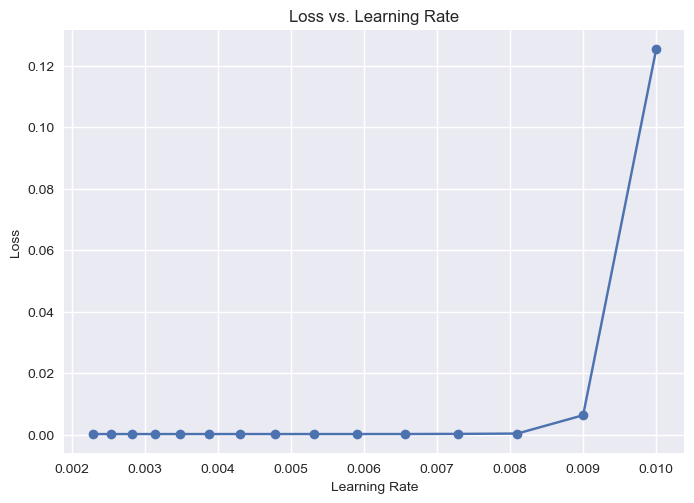

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define your learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 0.01
    decay_factor = 0.9
    return initial_lr * (decay_factor ** epoch)


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
    restore_best_weights=True,  # Restore the best weights when stopping
min_delta=0.00001)

# Create a model (you need to replace this with your actual model)
model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
#    BatchNormalization(),
    LSTM(512,name='LSTM_2'),
#    BatchNormalization(momentum=0.8),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])


checkpont_rnn = ModelCheckpoint(
    filepath='model_inder_rnn2',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1)

# Compile the model with an optimizer (Adam in this example)
optimizer = tf.keras.optimizers.Adam()  # Set initial learning rate to 0.0
model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)

# Set up the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define the number of epochs
num_epochs = 100

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
        print(learning_rates)
        losses.append(loss)
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")


# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

# Train your model
# history = model.fit(x_train, y_train, epochs=num_epochs, callbacks=[lr_scheduler, loss_lr_callback])
history = model_1.fit(
    my_window.train,
    epochs=num_epochs,
    validation_data=my_window.val,
    callbacks=[lr_scheduler, loss_lr_callback, early_stopping, checkpont_rnn]
)

# Access the losses from the training history
losses = history.history['loss']
learning_rates = [lr_schedule(epoch) for epoch in range(len(losses))]

# Plot the loss and learning rate
plt.plot(learning_rates, losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs. Learning Rate')
plt.show()


In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 86)             344       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1226752   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3460194 (13.20 MB)
Trainable params: 3460022 (13.20 MB)
Non-trainable params: 172 (688.00 Byte)
____________

In [27]:
# from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# !pip install pydot

In [29]:
# !pip install graphviz

Text(0.5, 1.0, 'RMSE Loss: Training and Validation')

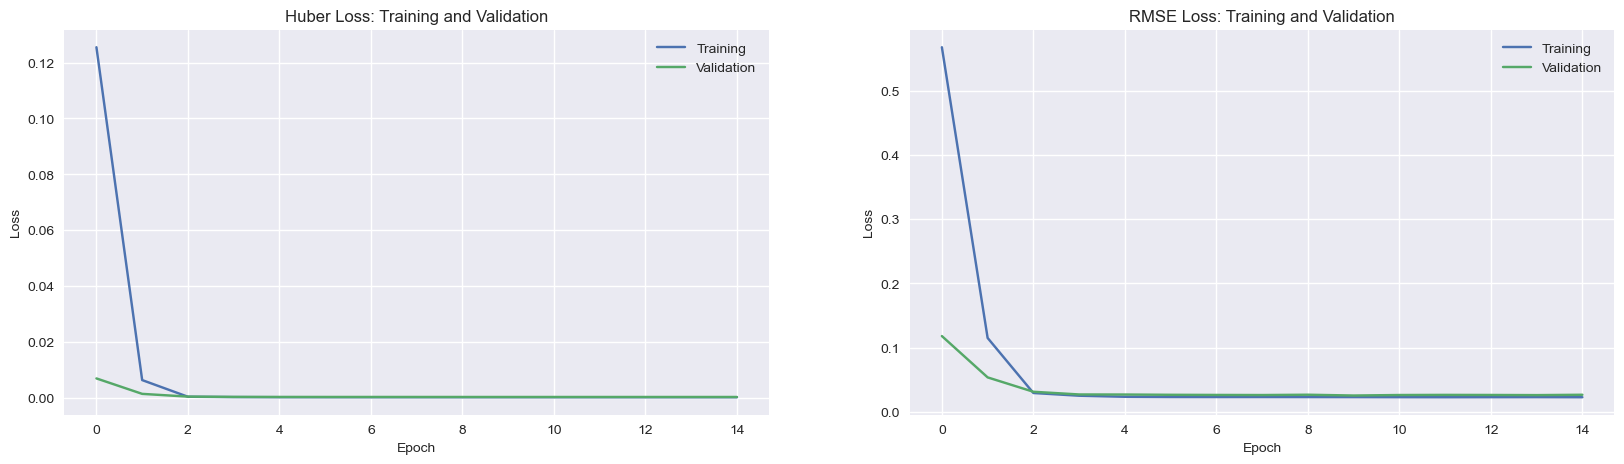

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('Huber Loss: Training and Validation')
plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('RMSE Loss: Training and Validation')

In [31]:
model_1.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 86), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 101ms/step - loss: 2.2639e-04 - root_mean_squared_error: 0.0213 - mae: 0.0145


[0.00022639385133516043, 0.021278811618685722, 0.014514070004224777]

In [32]:
# import tensorflow as tf
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import LSTM, Dense

# Create an example LSTM model


# Plot the model architecture graph and save it to a file (e.g., model.png)
plot_model(model_1, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
final_learning_rate = lr_schedule(num_epochs - 1)
print(f"The final learning rate used for the final model is: {final_learning_rate}")

The final learning rate used for the final model is: 2.9512665430652826e-07


In [34]:
learning_rates, losses

([0.01,
  0.009000000000000001,
  0.008100000000000001,
  0.007290000000000001,
  0.006561,
  0.005904900000000001,
  0.00531441,
  0.004782969000000001,
  0.004304672100000001,
  0.003874204890000001,
  0.003486784401000001,
  0.0031381059609000006,
  0.0028242953648100013,
  0.002541865828329001,
  0.002287679245496101],
 [0.1254698634147644,
  0.006389408838003874,
  0.00042517148540355265,
  0.00031286553712561727,
  0.0002724082150962204,
  0.0002632028190419078,
  0.0002627891954034567,
  0.00026186410104855895,
  0.0002603436296340078,
  0.00025929659022949636,
  0.0002588236820884049,
  0.00025855100830085576,
  0.00025850211386568844,
  0.0002585037727840245,
  0.00025849658413790166])